# SAP Cloud ALM Project and Task API Demo for Requirements

This notebook contains examples of SAP Business Hub API calls for SAP Cloud ALM for Implementation. The code cells below show how to use the Project and Task APIs to read and update Requirements.

The API information and specification is available here:

* https://api.sap.com/package/SAPCloudALM/rest - SAP Cloud ALM
* https://api.sap.com/api/CALM_PJM/overview - SAP Cloud ALM Projects
* https://api.sap.com/api/CALM_TKM/overview - SAP Cloud ALM Tasks

Please note the license and other terms and conditions contained in this notebook's repository: https://github.com/SAP-samples/cloud-alm-api-examples

## Python Dependencies Required

In order to run the samples in this notebook, install the following dependencies:

* Jupyter integration in Visual Studio Code: https://code.visualstudio.com/docs/python/jupyter-support 
* Python 3, a recent version, is Required. Python 3.8 was used here.
* Requests - for handling HTTP GET/POST/PATCH/DELETE Requests - https://docs.python-requests.org/en/latest/user/install/#install
* Requests-OAuthlib - for authentication with requests - https://requests-oauthlib.readthedocs.io/en/latest/index.html#installation
* Pandas - Python data analysis - https://pandas.pydata.org/docs/getting_started/install.html
* Plotly - for plotting interactive charts - https://plotly.com/python/getting-started/

## APIs called

API to get projects: https://<tenant url\>/api/imp-pjm-srv/v1/projects

API to get tasks, including Requirements: https://<tenant url\>/api/imp-tkm-srv/v1/tasks?projectId=<project ID\>

## Requirement Specifics

Requirements are treated exactly like tasks, and are accessed through the task API. There are several additional attributes relevant for requirements.

* Requirement task type = `CALMREQU`
* `subStatus` attribute for the Requirement Status
* `approvalState` = `APPROVED` if the requirement has been approved

Requirements have both a status, and corresponding to each status value, a subStatus.

* `CREATED` = In Specification, main status = CIPREQUOPEN
* `IN_REALIZATION` = In Realization, main status =  CIPREQUINP
* `APPROVED_FOR_DEPLOYMENT` = In Deployment, main status = CIPREQUINP
* `CONFIRMED` = Deployed, main status = CIPREQUCLOSE
* `NOT_PLANNED` = Not Planned, main status = CIPREQUNO

These values will be extended


---

## Authentication information

You must create a python module file called `apidata.py` and put the information specific to your tenant there. This inclduds

* OAuth2 client ID and secret
* Token url
* Base URL for API calls

Get client ID and secret variables from an external module: this information is senstive.

These items can be retrieved from the BTP Cockpit 

### Format of module apidata.py for import

```python
ptm_all_client_id = r'get your client ID from BTP Cockpit'
ptm_all_client_secret = r'get your client secret from BTP Cockpit'
token_url = 'your token url'
base_url = 'your base url'
```


In [24]:
import apidata as ad

client_id = ad.ptm_all_client_id
client_secret = ad.ptm_all_client_secret
token_url = ad.token_url
base_url = ad.base_url

### Get token for authentication

Call OAuth token API with credential information. Add the resulting header to all requests.

See Requests-OAuthlib documentation for Backend Application Flow:

* https://requests-oauthlib.readthedocs.io/en/latest/oauth2_workflow.html#backend-application-flow

In [47]:
import requests
from requests_oauthlib import OAuth2Session
from oauthlib.oauth2 import BackendApplicationClient

client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)
token = oauth.fetch_token(token_url=token_url, client_id=client_id,
        client_secret=client_secret)

hed = {'Authorization': 'Bearer ' + token['access_token']}        


---

## Perform GET request to retrieve list of all projects

Expected response: "200 OK"

In [48]:
response = requests.get(base_url + '/api/calm-projects/v1/projects', headers=hed)

print(response.status_code, response.reason)

200 OK


## Parse JSON into Pandas Dataframe

This takes the data returned from the projects API, which is in JSON format, and places it into a dataframe for further processing and analysis.

In [49]:
import pandas as pd

df = pd.json_normalize(response.json())

df

,id,name,status
0,b5de914d-6b46-4437-b702-15c763b94a12,kevin_dev_test_daily,O
1,64f6cacc-9ef9-4cf1-80b9-fe23d891feb4,Jekkrey_Test14,C
2,2495d431-04c8-4550-bd63-d8d3bc9cacbc,fixIssue,C
3,67710a32-6e43-4953-8582-4076b7fc2498,kevin Xu_test_ms_change_log,C
4,8719b16c-9911-4682-a1d3-1699599fa081,test4,C
...,...,...,...
345,acc75b0a-d25f-471f-b376-3c690d4c8f53,juni test project A,C
346,8c8a5044-d13c-474d-a8a7-f30ef871c3d1,Elaine Test Former Member 0427,O
347,235754ab-b5d6-42a4-a79f-b120dca4bee9,Missing saved data,O
348,c16024f8-32c9-421e-aef7-401066a6c120,Jun Test Project - Do not change,O


## Get a Project Name 

You may wish to adjust the code below to set a project name of your choosing, for example 'My API Test Project'. In this sample, we'll just take the first project in the list.


In [50]:
sample_project_name = df.iloc[0]['name'] # First project in the list
sample_project_name

'kevin_dev_test_daily'

### Override Sample Project Name for Demo

I'm setting my own project name here, beause I have one ready for my demos. You can do the same if you don't want to use the first project

In [29]:
# Uncomment and change to the name of a project you would like to use:

#sample_project_name = 'API Demo Project'

## Get ID of a Selected Project

Read ID of project 'Show & Tell 2021-Apr-30' from dataframe

In [30]:
stPrjID = df.loc[df['name'] == sample_project_name]
show_tell_prj = stPrjID['id'].values[0]
print('Project:', stPrjID['name'].values[0], 'ID:', show_tell_prj)

Project: Gordon Demo Project ID: 17a825f9-b4b5-4685-8396-59d5c80dc15c



---

## Read Task list from selected project

Use GET request from tasks API with selected project ID as input parameter.

Expected response "200 OK"

In [31]:
taskURL = base_url + '/api/calm-tasks/v1/tasks?projectId=' + show_tell_prj

response = requests.get(taskURL, headers=hed)

print(response.status_code, response.reason)

200 OK


### Parse project task list JSON into dataframe

In [32]:
df_stTasks = pd.json_normalize(response.json())

df_stTasks.head()

,id,projectId,title,type,status,externalId,dueDate,priorityId,assigneeId,assigneeName,...,subStatus,approvalState,scopeId,scopeName,assignedRoleId,assignedRoleName,storyPoints,obsolete,createdTimestamp,lastChangedTimestamp
0,e61f8de0-bd33-4c95-8d0b-2d71504a5c81,17a825f9-b4b5-4685-8396-59d5c80dc15c,Requirement with tags,CALMREQU,CIPREQUOPEN,None,2022-03-22,30,gordon.mcdorman@sap.com,Gordon Leslie McDorman,...,CREATED,APPROVED,b8b7654e-53e8-4e5b-9097-40e9a57634da,02 Scope,None,None,NaN,None,2022-01-05T11:06:16.454238Z,2022-04-20T15:32:18.903770Z
1,abea8f4f-9700-43f0-95ef-bc6d036d21fe,17a825f9-b4b5-4685-8396-59d5c80dc15c,New title of defect mod,CALMDEF,CIPDFCTINP,None,2022-05-15,30,tom.petty@sap-test.de,tom.petty@sap-test.de,...,DFC_RETEST_REQ,None,None,None,None,None,NaN,None,2022-04-27T14:07:16.437334Z,2022-04-27T14:20:11.405965Z
2,8d800b70-7fec-4557-95a4-3ce12d211790,17a825f9-b4b5-4685-8396-59d5c80dc15c,Defect in progress,CALMDEF,CIPDFCTINP,None,None,30,None,None,...,DFC_INP,None,None,None,None,None,NaN,None,2022-04-27T15:18:58.363585Z,2022-04-27T15:18:58.363585Z
3,84bc1f89-f751-46d9-b56d-a243564b78f5,17a825f9-b4b5-4685-8396-59d5c80dc15c,Defect postponed,CALMDEF,CIPDFCTBLK,None,None,30,None,None,...,DFC_POSTPONE,None,None,None,None,None,NaN,None,2022-04-27T15:19:16.807505Z,2022-04-27T15:19:16.807505Z
4,5bb3b76c-4122-4dd8-aa79-50ab0fed0856,17a825f9-b4b5-4685-8396-59d5c80dc15c,Defect closed,CALMDEF,CIPDFCTDONE,None,None,30,None,None,...,DFC_CLOSED,None,None,None,None,None,NaN,None,2022-04-27T15:19:29.830274Z,2022-04-27T15:19:29.830274Z


In [33]:
df_stTasks

,id,projectId,title,type,status,externalId,dueDate,priorityId,assigneeId,assigneeName,...,subStatus,approvalState,scopeId,scopeName,assignedRoleId,assignedRoleName,storyPoints,obsolete,createdTimestamp,lastChangedTimestamp
0,e61f8de0-bd33-4c95-8d0b-2d71504a5c81,17a825f9-b4b5-4685-8396-59d5c80dc15c,Requirement with tags,CALMREQU,CIPREQUOPEN,None,2022-03-22,30,gordon.mcdorman@sap.com,Gordon Leslie McDorman,...,CREATED,APPROVED,b8b7654e-53e8-4e5b-9097-40e9a57634da,02 Scope,None,None,NaN,None,2022-01-05T11:06:16.454238Z,2022-04-20T15:32:18.903770Z
1,abea8f4f-9700-43f0-95ef-bc6d036d21fe,17a825f9-b4b5-4685-8396-59d5c80dc15c,New title of defect mod,CALMDEF,CIPDFCTINP,None,2022-05-15,30,tom.petty@sap-test.de,tom.petty@sap-test.de,...,DFC_RETEST_REQ,None,None,None,None,None,NaN,None,2022-04-27T14:07:16.437334Z,2022-04-27T14:20:11.405965Z
2,8d800b70-7fec-4557-95a4-3ce12d211790,17a825f9-b4b5-4685-8396-59d5c80dc15c,Defect in progress,CALMDEF,CIPDFCTINP,None,None,30,None,None,...,DFC_INP,None,None,None,None,None,NaN,None,2022-04-27T15:18:58.363585Z,2022-04-27T15:18:58.363585Z
3,84bc1f89-f751-46d9-b56d-a243564b78f5,17a825f9-b4b5-4685-8396-59d5c80dc15c,Defect postponed,CALMDEF,CIPDFCTBLK,None,None,30,None,None,...,DFC_POSTPONE,None,None,None,None,None,NaN,None,2022-04-27T15:19:16.807505Z,2022-04-27T15:19:16.807505Z
4,5bb3b76c-4122-4dd8-aa79-50ab0fed0856,17a825f9-b4b5-4685-8396-59d5c80dc15c,Defect closed,CALMDEF,CIPDFCTDONE,None,None,30,None,None,...,DFC_CLOSED,None,None,None,None,None,NaN,None,2022-04-27T15:19:29.830274Z,2022-04-27T15:19:29.830274Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,9a145798-ced9-4a4a-b692-1ab2dc849ad7,17a825f9-b4b5-4685-8396-59d5c80dc15c,New defect spreadsheet upload 3,CALMDEF,CIPDFCTINP,,2022-04-29,30,None,None,...,DFC_RETEST_REQ,None,None,None,None,None,NaN,None,2022-04-29T07:42:48.006446Z,2022-04-29T07:42:48.006446Z
356,74aa3f48-fb82-4cb1-97a1-cb141246ce90,17a825f9-b4b5-4685-8396-59d5c80dc15c,New defect spreadsheet upload 4,CALMDEF,CIPDFCTINP,,2022-04-29,30,None,None,...,DFC_INP,None,None,None,None,None,NaN,None,2022-04-29T07:42:48.006446Z,2022-04-29T07:42:48.006446Z
357,572356d9-5ced-4c5a-a05b-3f4f7c0d64a4,17a825f9-b4b5-4685-8396-59d5c80dc15c,New defect spreadsheet upload 5,CALMDEF,CIPDFCTBLK,,2022-04-29,30,None,None,...,DFC_POSTPONE,None,None,None,None,None,NaN,None,2022-04-29T07:42:48.006446Z,2022-04-29T07:42:48.006446Z
358,ff5e65fa-12f2-42ca-bfc9-f1142721f73e,17a825f9-b4b5-4685-8396-59d5c80dc15c,New defect spreadsheet upload 6,CALMDEF,CIPDFCTINP,,2022-04-29,30,None,None,...,DFC_RETEST_REQ,None,None,None,None,None,NaN,None,2022-04-29T07:42:48.006446Z,2022-04-29T07:42:48.006446Z


### Barchart plot of tasks by type

Use built-in matplotlib of Pandas for quick data exploration

Requirements have type `CALMREQU`.

<AxesSubplot:title={'center':'Task Type'}, ylabel='type'>

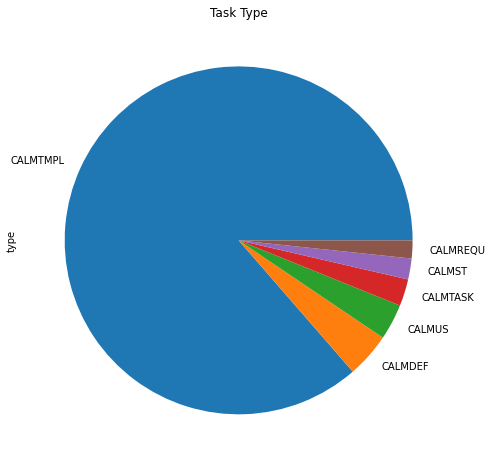

In [34]:
df_stTasks.type.value_counts().plot.pie(title="Task Type", figsize=(18,8))

### Analyze Requirements by substatus, approvalState

Count Requirements in each substatus (called "Requirement Status")

Count approved Requirements

In [35]:
df_stTasks.groupby(by=['subStatus'])['id'].count().reset_index()

,subStatus,id
0,CREATED,5
1,DFC_CLOSED,2
2,DFC_INP,2
3,DFC_NEW,2
4,DFC_POSTPONE,2
5,DFC_RETEST_REQ,7
6,TO_BE_APPROVED,1


<AxesSubplot:title={'center':'Requirement Status'}, ylabel='subStatus'>

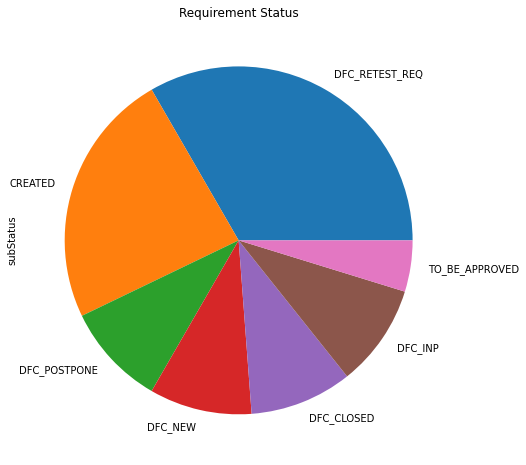

In [36]:
df_stTasks.subStatus.value_counts().plot.pie(title="Requirement Status", figsize=(18,8))

In [37]:
df_stTasks.groupby(by=['approvalState'])['id'].count().reset_index()

,approvalState,id
0,APPROVED,1



---

## Create Requirement

* Endpoint: `https://<tenant url>/api/imp-tkm-srv/v1/tasks`

* Type: Post

Append a timestamp to the end of the new task title for easy identification in UI.

Expected response `201 Created`


In [38]:
import datetime

isoNow = datetime.datetime.now().isoformat()

taskCreateURL = base_url + '/api/calm-tasks/v1/tasks'

taskData = {
    "projectId": show_tell_prj,
    "title": "Notebook API test Requirement " + isoNow,
    "type": "CALMREQU",
    "description": "test description. hello world",
    "assigneeId": "test.user@example.com"
}

response = requests.post(taskURL, headers=hed, json=taskData)

print(response.status_code, response.reason)

newTaskID = response.json()['id']
print("New Requirement ID:", newTaskID)

201 Created
New Requirement ID: ab401d46-ff70-4027-b9ec-5f2ed8aeb955



---

## Get Requirement Details

Use GET request to read details of requirement just created

* Endpoint: `https://<tenant url>/rest/tkm/v1/tasks/{taskGuid}`

* Type: Get

Expected response: `200 OK`


In [39]:
taskURL = base_url + '/api/calm-tasks/v1/tasks/' + newTaskID

response = requests.get(taskURL, headers=hed)

print(response.status_code, response.reason)

200 OK


### Save and print response JSON

In [40]:
readTask = response.json()
readTask

{'id': 'ab401d46-ff70-4027-b9ec-5f2ed8aeb955',
 'projectId': '17a825f9-b4b5-4685-8396-59d5c80dc15c',
 'title': 'Notebook API test Requirement 2022-04-29T12:53:27.818360',
 'type': 'CALMREQU',
 'status': 'CIPREQUOPEN',
 'externalId': None,
 'dueDate': '2021-11-30',
 'priorityId': 30,
 'assigneeId': 'test.user@example.com',
 'assigneeName': 'test.user@example.com',
 'timeboxName': 'Prepare',
 'timeboxStartDate': '2021-11-01',
 'timeboxEndDate': '2021-11-30',
 'parentId': None,
 'subStatus': 'CREATED',
 'approvalState': None,
 'description': 'test description. hello world',
 'scopeId': None,
 'scopeName': None,
 'assignedRoleId': None,
 'assignedRoleName': None,
 'storyPoints': None,
 'obsolete': None,
 'createdTimestamp': '2022-04-29T10:53:28.355651Z',
 'lastChangedTimestamp': '2022-04-29T10:53:28.355651Z'}


---

## Modify Requirement

Use PATCH method to update Requirement attributes

Expected response: `200 OK`

In [41]:
taskToModify = {}

taskToModify['title'] = readTask['title'] + ' mod'
taskToModify['dueDate'] = '2022-04-09'
taskToModify['status'] = 'CIPREQUINP'
taskToModify['description'] = 'This is a new <b>Description</b>. It replaces the old description'

### Set subStatus, approvalState

Set the `subStatus` and `approvalState` attributes, which are the Requirement specific attributes


In [42]:
taskToModify['subStatus'] = 'APPROVED_FOR_DEPLOYMENT'
taskToModify['approvalState'] = 'APPROVED'

In [43]:
taskURL = base_url + '/api/calm-tasks/v1/tasks/' + newTaskID

response = requests.patch(taskURL, headers=hed, json=taskToModify)

print(response.status_code, response.reason)

200 OK


In [44]:
response.json()

{'id': 'ab401d46-ff70-4027-b9ec-5f2ed8aeb955',
 'projectId': '17a825f9-b4b5-4685-8396-59d5c80dc15c',
 'title': 'Notebook API test Requirement 2022-04-29T12:53:27.818360 mod',
 'type': 'CALMREQU',
 'status': 'CIPREQUINP',
 'externalId': None,
 'dueDate': '2022-04-09',
 'priorityId': 30,
 'assigneeId': 'test.user@example.com',
 'assigneeName': 'test.user@example.com',
 'timeboxName': 'Prepare',
 'timeboxStartDate': '2021-11-01',
 'timeboxEndDate': '2021-11-30',
 'parentId': None,
 'subStatus': 'APPROVED_FOR_DEPLOYMENT',
 'approvalState': 'APPROVED',
 'description': 'This is a new <b>Description</b>. It replaces the old description',
 'scopeId': None,
 'scopeName': None,
 'assignedRoleId': None,
 'assignedRoleName': None,
 'storyPoints': None,
 'obsolete': None,
 'createdTimestamp': '2022-04-29T10:53:28.355651Z',
 'lastChangedTimestamp': '2022-04-29T10:53:30.310722Z'}


---

## Delete Requirement

DELETE method - the system **forbids** deletion of **approved** Requirements

Expected response: `204 No Content` if the Requirement is not approved, `400 Bad Request` if the Requirement is approved.


In [45]:
taskURL = base_url + '/api/calm-tasks/v1/tasks/' + newTaskID

# Uncomment code below to test deletion

#response = requests.delete(taskURL, headers=hed)

#print(response.status_code, response.reason)